***Skin Cancer EDA & Binary Classification***

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms, datasets

from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve, auc
from imgaug import augmenters as iaa
from tqdm.notebook import tqdm
import time
import re
import glob
# sklearn impute
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier, LGBMRegressor
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Plot setting across notebook
rc = {'figure.figsize':(8,4),
      'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '.8',
      'font.size' : 10}
plt.rcParams.update(rc)
sns.set(rc=rc)


In [3]:
# Load metadata 
train_metadata = pd.read_csv('/kaggle/input/isic-data/train-metadata.csv',low_memory=False)
test_metadata = pd.read_csv('/kaggle/input/isic-data/test-metadata.csv',low_memory=False)
sample_submission = pd.read_csv('/kaggle/input/isic-data/sample_submission.csv',low_memory=False)
ss_df = sample_submission
train_df = train_metadata
test_df = test_metadata
image_folder_path='/kaggle/input/isic-data/train-image/image'
csv_file_path='/kaggle/input/isic-data/train-metadata.csv'

In [4]:
display(train_df)
print(train_df.describe())
print(train_df.info())
print(train_df.isnull().sum())

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,IL_9852274,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


              target     age_approx  clin_size_long_diam_mm       tbp_lv_A  \
count  401059.000000  398261.000000           401059.000000  401059.000000   
mean        0.000980      58.012986                3.930827      19.974007   
std         0.031288      13.596165                1.743068       3.999489   
min         0.000000       5.000000                1.000000      -2.487115   
25%         0.000000      50.000000                2.840000      17.330821   
50%         0.000000      60.000000                3.370000      19.801910   
75%         0.000000      70.000000                4.380000      22.304628   
max         1.000000      85.000000               28.400000      48.189610   

         tbp_lv_Aext       tbp_lv_B    tbp_lv_Bext       tbp_lv_C  \
count  401059.000000  401059.000000  401059.000000  401059.000000   
mean       14.919247      28.281706      26.913015      34.786341   
std         3.529384       5.278676       4.482994       5.708469   
min        -9.080269 

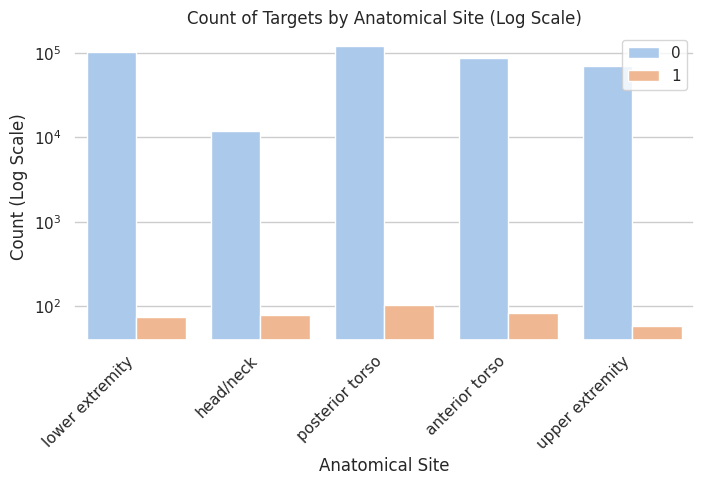

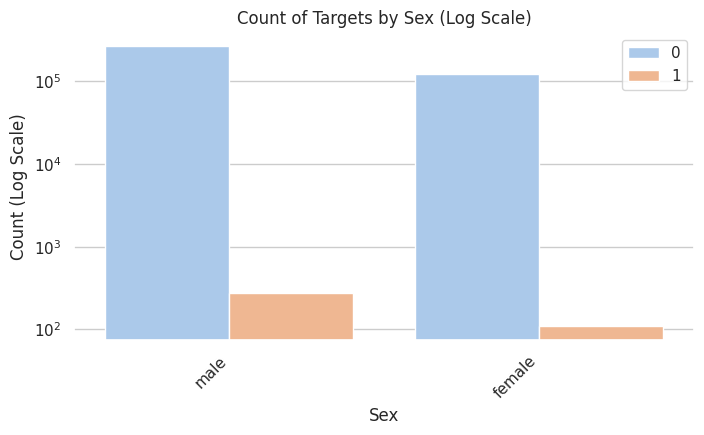

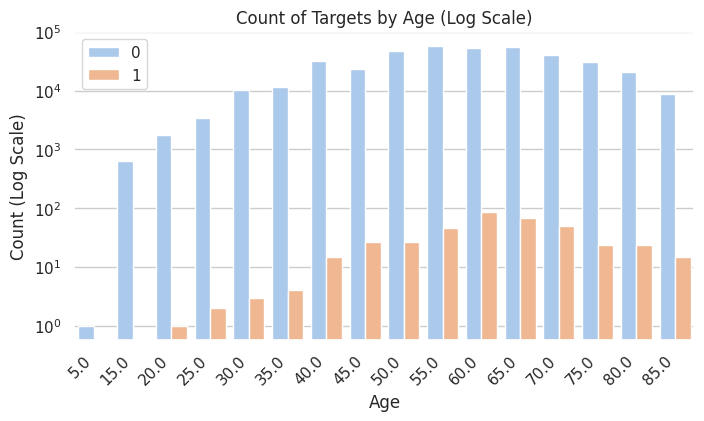

In [5]:
def plot_countplot(df, x_col, hue_col, x_label, y_label, title, logscale=False):
    sns.countplot(x=x_col, hue=hue_col, data=df, palette='pastel')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc='best')
    if logscale:
        plt.yscale('log')
    plt.show()

# Anatomical site
plot_countplot(train_df, 'anatom_site_general', 'target', 'Anatomical Site', 'Count (Log Scale)', 'Count of Targets by Anatomical Site (Log Scale)', logscale=True)

# Gender Distribution
plot_countplot(train_df, 'sex', 'target', 'Sex', 'Count (Log Scale)', 'Count of Targets by Sex (Log Scale)', logscale=True)

#Age plot
plot_countplot(train_df, 'age_approx', 'target', 'Age', 'Count (Log Scale)', 'Count of Targets by Age (Log Scale)', logscale=True)

The total number of malignant and benign cases

In [6]:
train_df['target'].value_counts().sort_index()

target
0    400666
1       393
Name: count, dtype: int64

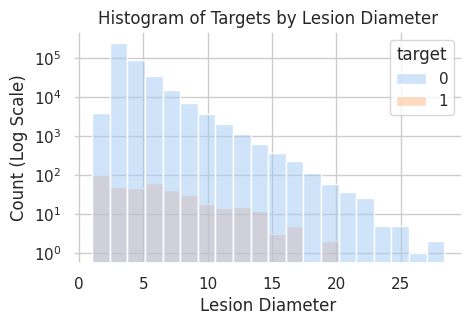

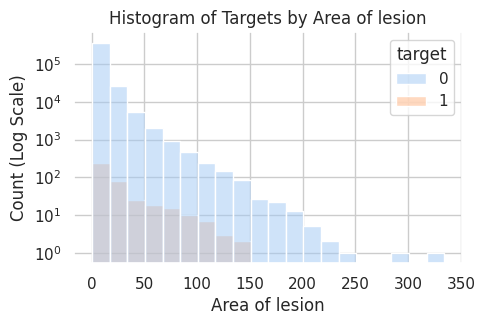

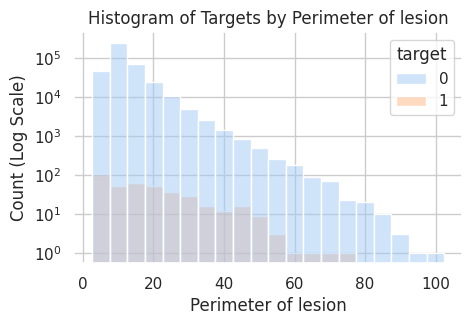

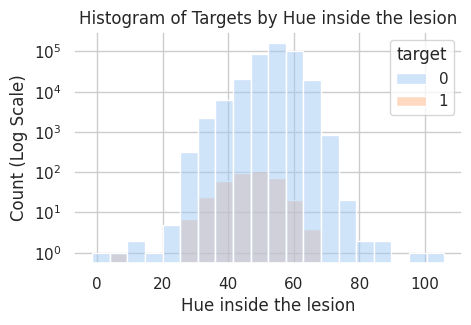

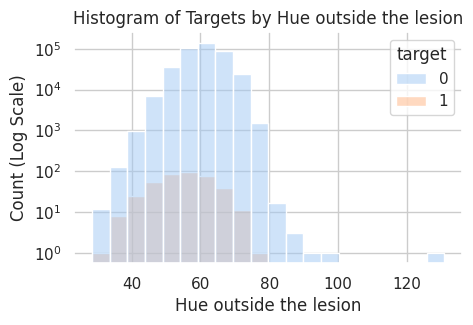

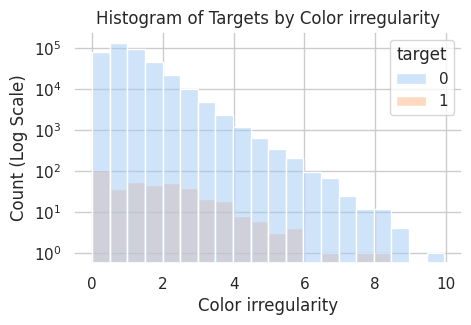

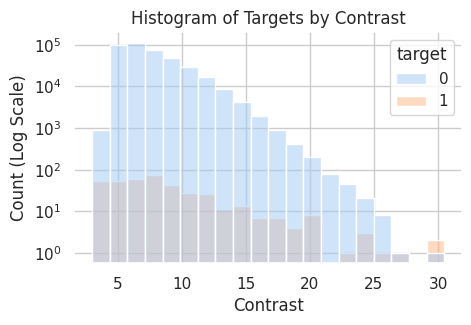

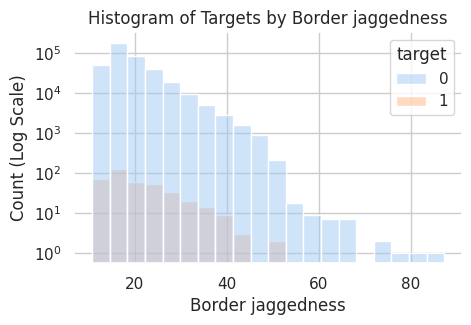

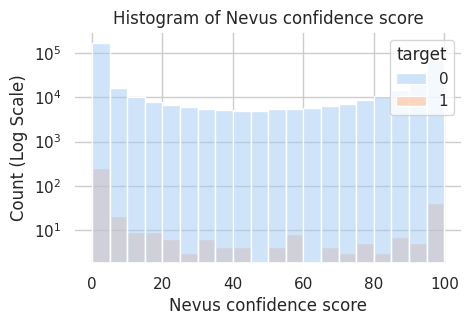

In [7]:
def plot_hist(df, x_col, hue_col, x_label, title, logscale=False):
    plt.figure(figsize=(5,3))
    sns.histplot(x=x_col, hue=hue_col, data=df, bins=20, palette='pastel')
    plt.xlabel(x_label)
    plt.title(title)
    if logscale:
        plt.yscale('log')
        plt.ylabel('Count (Log Scale)')
    plt.show()
    
## Size related measures
# Lesion Diameter
plot_hist(train_df, 'clin_size_long_diam_mm', 'target', 'Lesion Diameter', 'Histogram of Targets by Lesion Diameter', logscale=True)

# Area of lesion
plot_hist(train_df, 'tbp_lv_areaMM2', 'target', 'Area of lesion', 'Histogram of Targets by Area of lesion', logscale=True)

# Perimeter of lesion
plot_hist(train_df, 'tbp_lv_perimeterMM', 'target', 'Perimeter of lesion', 'Histogram of Targets by Perimeter of lesion', logscale=True)

# Hue inside the lesion
plot_hist(train_df, 'tbp_lv_H', 'target', 'Hue inside the lesion', 'Histogram of Targets by Hue inside the lesion', logscale=True)

# Hue outside the lesion
plot_hist(train_df, 'tbp_lv_Hext', 'target', 'Hue outside the lesion', 'Histogram of Targets by Hue outside the lesion', logscale=True)

# Color irregularity
plot_hist(train_df, 'tbp_lv_color_std_mean', 'target', 'Color irregularity', 'Histogram of Targets by Color irregularity', logscale=True)

# Contrast between the lesion and its immediate surrounding skin
plot_hist(train_df, 'tbp_lv_deltaLBnorm', 'target', 'Contrast', 'Histogram of Targets by Contrast', logscale=True)

# Border jaggedness
plot_hist(train_df, 'tbp_lv_area_perim_ratio', 'target', 'Border jaggedness', 'Histogram of Targets by Border jaggedness', logscale=True)

# Nevus confidence score
plot_hist(train_df, 'tbp_lv_nevi_confidence', 'target', 'Nevus confidence score', 'Histogram of Nevus confidence score', logscale=True)


PreProcessing

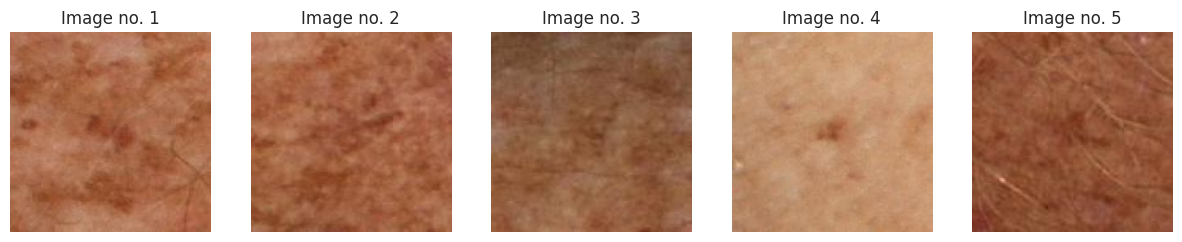

In [8]:
import random
# Display 5 random images from a folder
def display_random_images_from_folder(image_folder_path, num_images=5):
    # Get all image file names from the folder
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Select random images
    random_images = random.sample(image_files, num_images)
    
    # Display images
    plt.figure(figsize=(15, 5))
    for i, image_file in enumerate(random_images):
        img = Image.open(os.path.join(image_folder_path, image_file))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image no. {i+1}")
    plt.show()
display_random_images_from_folder(image_folder_path)

In [9]:
def handle_missing_data(df):
    """
    categorical variable -> replace NaN with mode
    numerical variable -> replace NaN with mean
    """
    # Divide columns into categorical and numerical columns
    cat_columns = df.select_dtypes(include=['object', 'category']).columns
    num_columns = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Define imputer
    cat_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    num_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    
    # Apply transformation
    df[cat_columns] = cat_imp.fit_transform(df[cat_columns])
    df[num_columns] = num_imp.fit_transform(df[num_columns])
        
    return df

    
def drop_unnecessary_columns(df, drop_col_names):
    columns_to_drop = [col for col in drop_col_names if col in df.columns]
    return df.drop(columns=columns_to_drop)


def perform_one_hot_encoding(df, cat_colmuns: list[str], one_hot_encoder=None, drop_original_col=True):
    """
    Create one-hot encoded variables of given categorical variables.
    """    
    if one_hot_encoder==None:
        enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        data_one_hot = enc.fit_transform(df[cat_colmuns]) # apply one-hot encoding to the target categorycal columns
    else:
        enc = one_hot_encoder
        data_one_hot = enc.transform(df[cat_colmuns]) # apply one-hot encoding to the target categorycal columns
    col_name_one_hot = enc.get_feature_names_out(cat_colmuns) # get names of one-hot encoded columns
    df_one_hot = pd.DataFrame(data_one_hot, columns=col_name_one_hot, index=df.index) # create a new df with new column names
    if drop_original_col:
        df_all = pd.concat([df.drop(cat_colmuns, axis=1), df_one_hot], axis=1) # drop redundant columns and concatnate with the original data
    else:
        df_all = pd.concat([df, df_one_hot], axis=1) # concatnate with the original data
    return df_all, enc


def clean_column_names(df):
    """
    Clean column names by replacing or removing special characters.
    """
    df.columns = [re.sub(r'[^0-9a-zA-Z_]', '_', col) for col in df.columns]
    return df


def perform_standardization(df, TARGET_COL='target'):
    # Extract all numerical columns except target
    num_columns = df.select_dtypes(include=['int64', 'float64']).columns
    num_columns = [col for col in num_columns if col != TARGET_COL]

    # Stamdardize numerical variables
    scaler = StandardScaler()
    df[num_columns] = scaler.fit_transform(df[num_columns])

    return df


CAT_COLUMNS = ['sex', 'anatom_site_general', 'image_type', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution', 'copyright_license', 'mel_mitotic_index']
# Drop the columns 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5'
# because they mostly contain NaN values or duplicate information found in other columns.
COLUMNS_TO_DROP = ['patient_id', 'lesion_id', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'copyright_license', 'attribution', 'image_type', 'mel_thick_mm', 'mel_mitotic_index', 'tbp_lv_dnn_lesion_confidence']
CAT_COLUMNS_TO_ONE_HOT = [_c for _c in CAT_COLUMNS if _c not in COLUMNS_TO_DROP+['isic_id']]

print()
print('===Before preprocessing (Train data)===')
print(f"Number of total columns: {len(train_df.axes[1])}")
print(f"Number of numerical columns: {len(train_df.select_dtypes(include=['int64', 'float64']).columns)}")
print(f"Number of categorical columns: {len(train_df.select_dtypes(include=['object', 'category']).columns)}")

train_df_processed = handle_missing_data(train_df.copy())
train_df_processed = drop_unnecessary_columns(train_df_processed, COLUMNS_TO_DROP)
train_df_processed, train_enc = perform_one_hot_encoding(train_df_processed, CAT_COLUMNS_TO_ONE_HOT)
train_df_processed = clean_column_names(train_df_processed)
train_df_processed = perform_standardization(train_df_processed)

print()
print('===After preprocessing (Train data)===')
print(f"Number of total columns: {len(train_df_processed.axes[1])}")
print(f"Number of numerical columns: {len(train_df_processed.select_dtypes(include=['int64', 'float64']).columns)}")
print(f"Number of categorical columns: {len(train_df_processed.select_dtypes(include=['object', 'category']).columns)}")


# Preprocess test data
test_df_processed = handle_missing_data(test_df.copy())
test_df_processed = drop_unnecessary_columns(test_df_processed, COLUMNS_TO_DROP)
test_df_processed, _ = perform_one_hot_encoding(test_df_processed, CAT_COLUMNS_TO_ONE_HOT, one_hot_encoder=train_enc)
test_df_processed = clean_column_names(test_df_processed)
test_df_processed = perform_standardization(test_df_processed)


===Before preprocessing (Train data)===
Number of total columns: 55
Number of numerical columns: 37
Number of categorical columns: 18

===After preprocessing (Train data)===
Number of total columns: 74
Number of numerical columns: 73
Number of categorical columns: 1


In [10]:
class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:
    '''
    2024 ISIC Challenge metric: pAUC
    
    Given a solution file and submission file, this function returns the
    the partial area under the receiver operating characteristic (pAUC) 
    above a given true positive rate (TPR) = 0.80.
    '''

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    # check submission is numeric
    if not pd.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission target column must be numeric')

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(solution.values)-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(submission.values)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)
    
    return(partial_auc)

Applying Model Hyperparameter Tuning For Better Results

In [11]:
def initialize_model(model_name):
    """
    Initialize a different type of model
    """
    if model_name=='LogisticRegression':
        params = {
            'penalty': 'l2',
            'C': 1,
            'solver': 'lbfgs',
            'max_iter': 800,
            'tol': 1e-5,
            'fit_intercept': True
        }
        model = LogisticRegression(**params)
    elif model_name=='XGBoost':
        params = {
            'objective': 'binary:logistic', 
            'n_estimators': 1000, # Number of boosting rounds or trees
            'max_depth': 3, # Maximum depth of a tree
            'learning_rate': 0.01,
            'subsample': 0.8, # Fraction of samples to be used for each boosting round
            'colsample_bytree': 0.2, # Fraction of features to be used for each tree
            'alpha': 1e-01, # L1 regularization term on weights
            'lambda': 3, # L2 regularization term on weights
            'tree_method': 'hist' # Tree construction algorithm
        }
        model = xgb.XGBClassifier(**params)
    elif model_name=='AdaBoost':
        params = {
            'n_estimators': 250,
            'learning_rate': 0.15,
            'algorithm': 'SAMME.R',
            'random_state': 0
        }
        model = AdaBoostClassifier(**params)
    elif model_name=='LGBMClassifier':
        params = {
            'n_estimators': 2000,  # Number of boosting rounds or trees
            'learning_rate': 0.01,
            'pos_bagging_fraction': 0.75,  # Fraction of positive samples to use in each boosting round
            'neg_bagging_fraction': 0.05,  # Fraction of negative samples to use in each boosting round
            'feature_fraction': 0.5,  # Fraction of features to be used for each tree
            'lambda_l1': 0.5,  # L1 regularization term on weights to prevent overfitting
            'lambda_l2': 3,  # L2 regularization term on weights to prevent overfitting
            'num_leaves': 100,
            'max_depth': 4,
            'objective': 'binary',
            'random_state': 0,
            'bagging_freq': 1,  # Frequency for bagging. 1 means bagging is performed at every iteration.
            'verbosity': -1  # Controls the level of logging (lower means less logging)
        }
        model = LGBMClassifier(**params)
    elif model_name=='SVM':
        params = {
            'C': 0.5,
            'kernel': 'rbf',
            'gamma': 'scale',
            'tol': 1e-5,
            'max_iter': 1000
        }
        model = SVC(**params)
        
    return model


Train LogisticRegression
Iteration 1, Train loss: 0.0622, Validation loss: 0.0487, Time taken: 1.58 seconds
Iteration 2, Train loss: 0.0636, Validation loss: 0.0553, Time taken: 1.31 seconds
Iteration 3, Train loss: 0.0641, Validation loss: 0.0621, Time taken: 1.12 seconds

Train AdaBoost
Iteration 1, Train loss: 0.1156, Validation loss: 0.0697, Time taken: 28.37 seconds
Iteration 2, Train loss: 0.126, Validation loss: 0.0666, Time taken: 28.25 seconds
Iteration 3, Train loss: 0.1124, Validation loss: 0.0894, Time taken: 28.47 seconds

Train XGBoost
Iteration 1, Train loss: 0.1359, Validation loss: 0.0662, Time taken: 4.69 seconds
Iteration 2, Train loss: 0.1449, Validation loss: 0.0687, Time taken: 4.57 seconds
Iteration 3, Train loss: 0.134, Validation loss: 0.0936, Time taken: 4.56 seconds

Train LGBMClassifier
Iteration 1, Train loss: 0.1705, Validation loss: 0.1163, Time taken: 31.2 seconds
Iteration 2, Train loss: 0.1705, Validation loss: 0.1155, Time taken: 31.14 seconds
Iterat

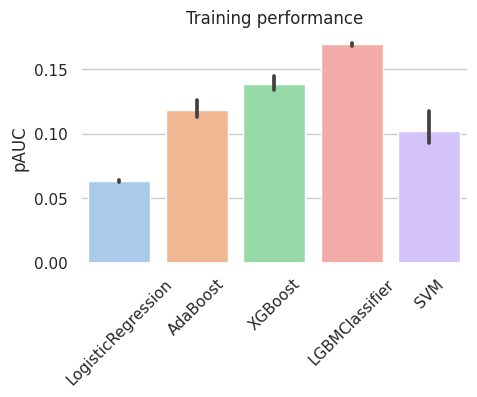

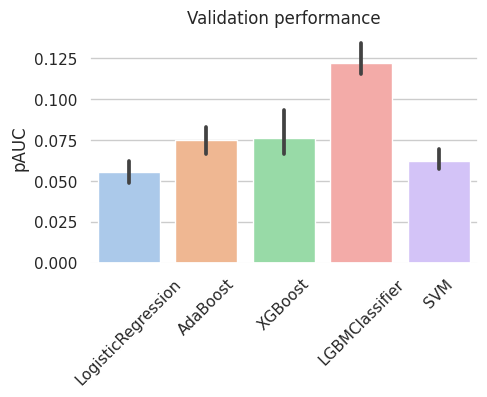

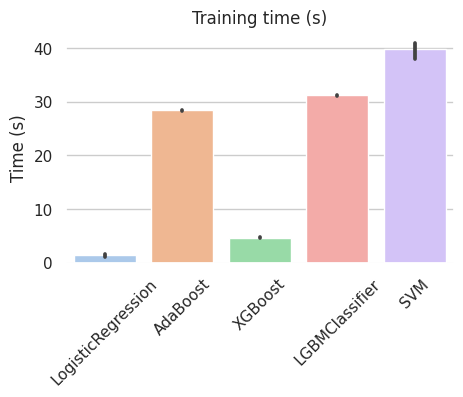

In [12]:
def train_multiple_models(X, y, model_names, K=3, seed=42, over_sampling_ratio=0.003, under_sampling_ratio=0.5):
    scores_train_all=[]
    scores_valid_all=[]
    times_all = []
    
    for model_name in model_names:
        print()
        print(f"Train {model_name}")
        model = Pipeline([
            ('sampler_1', RandomOverSampler(sampling_strategy=over_sampling_ratio, random_state=seed)),
            ('sampler_2', RandomUnderSampler(sampling_strategy=under_sampling_ratio, random_state=seed)),
            ('classifier', initialize_model(model_name))
        ])
        scores_train = []
        scores_valid = []
        times = []

        kf = KFold(n_splits=K)
        for i, (train_ind, val_ind) in enumerate(kf.split(train_df_processed), start=1):
            start_time = time.time()
            
            # Prepare training and validation data
            X_train, X_val = X.iloc[train_ind], X.iloc[val_ind]
            X_train_drop, X_val_drop = X_train.loc[:, X_train.columns!='isic_id'], X_val.loc[:, X_val.columns!='isic_id']
            y_train, y_val = y.iloc[train_ind], y.iloc[val_ind]
            y_train_drop, y_val_drop = y_train.loc[:, y_train.columns!='isic_id'], y_val.loc[:, y_val.columns!='isic_id']
            
            # Train a model
            model.fit(X_train_drop, y_train_drop)
            
            # Compute train loss
            pred_train = pd.DataFrame(model.predict(X_train_drop))
            pred_train['isic_id'] = X_train['isic_id']
            score_train = score(y_train, pred_train, "isic_id")
            scores_train.append(score_train)
            
            # Compute validation loss
            pred_valid = pd.DataFrame(model.predict(X_val_drop))
            pred_valid['isic_id'] = X_val['isic_id']
            score_valid = score(y_val, pred_valid, "isic_id")
            scores_valid.append(score_valid)

            # Compute the time taken    
            end_time = time.time()
            iteration_time = end_time - start_time
            times.append(iteration_time)
            
            print(f"Iteration {i}, Train loss: {np.round(score_train,4)}, Validation loss: {np.round(score_valid,4)}, Time taken: {np.round(iteration_time, 2)} seconds")
            
        scores_train_all.append(scores_train)
        scores_valid_all.append(scores_valid)
        times_all.append(times)
        
    return scores_train_all, scores_valid_all, times_all


def plot_bar(df, y_label, title):
    plt.figure(figsize=(5,3))
    sns.barplot(df, palette='pastel')
    plt.xticks(rotation=45)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()
        
        
model_names = ['LogisticRegression', 'AdaBoost', 'XGBoost', 'LGBMClassifier', 'SVM']
# model_names = ['LGBMClassifier']
y = train_df_processed[['isic_id', 'target']]
X = train_df_processed.drop(columns=['target'])
scores_train_all, scores_valid_all, times_all = train_multiple_models(X, y, model_names)

# Plotting
scores_train_all_df = pd.DataFrame(scores_train_all, index=model_names).T
scores_valid_all_df = pd.DataFrame(scores_valid_all, index=model_names).T
times_all_df = pd.DataFrame(times_all, index=model_names).T
plot_bar(scores_train_all_df, 'pAUC', 'Training performance')
plot_bar(scores_valid_all_df, 'pAUC', 'Validation performance')
plot_bar(times_all_df, 'Time (s)', 'Training time (s)')

In [13]:
def create_columns(df):
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"]**2)
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"]**2 + df["tbp_lv_deltaB"]**2 + df["tbp_lv_deltaL"]**2)
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"]**2 + df["tbp_lv_y"]**2 + df["tbp_lv_z"]**2)
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    # df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"] # remove because this column has been already removed during preprocessing
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]

    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    # df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"] # remove because it contains inf
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"]**2 + df["tbp_lv_deltaB"]**2 + df["tbp_lv_deltaL"]**2) / 3)
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"] = np.arctan2(df["tbp_lv_y"], df["tbp_lv_x"])
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4

    return df

y = train_df_processed[['isic_id', 'target']]
X_added = create_columns(train_df_processed.drop(columns=['target'])) # Add new features



Train LogisticRegression

Train XGBoost

Train LGBMClassifier

Train VotingClassifier


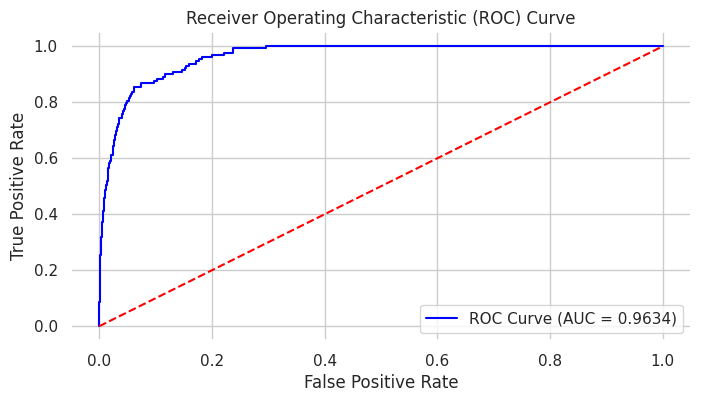

Train loss: 0.1646, Validation loss: 0.1245, Recall: 0.876, Accuracy: 0.9002, Time taken: 62.69 seconds


In [14]:
from sklearn.metrics import recall_score, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def train_ensemble_model(X, y, model_names, seed=42, over_sampling_ratio=0.003, under_sampling_ratio=0.5):
    """
    Train all models included in the list
    Return train errors, validation errors, recall, accuracy, ROC curve, and time taken.
    """
    models = []

    # Prepare training and validation data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
    X_train_drop, X_val_drop = X_train.loc[:, X_train.columns != 'isic_id'], X_val.loc[:, X_val.columns != 'isic_id']
    y_train_drop, y_val_drop = y_train.loc[:, y_train.columns != 'isic_id'], y_val.loc[:, y_val.columns != 'isic_id']

    start_time = time.time()
    for model_name in model_names:
        print()
        print(f"Train {model_name}")
        # Build a pipeline with oversampling, undersampling, and the classifier
        model = Pipeline([
            ('sampler_1', RandomOverSampler(sampling_strategy=over_sampling_ratio, random_state=seed)),
            ('sampler_2', RandomUnderSampler(sampling_strategy=under_sampling_ratio, random_state=seed)),
            ('classifier', initialize_model(model_name))
        ])

        # Train the model
        model.fit(X_train_drop, y_train_drop)
        models.append((model_name, model))

    print()
    print(f"Train VotingClassifier")

    # Create and train the VotingClassifier ensemble
    ensemble_model = VotingClassifier(estimators=models, voting='soft')
    ensemble_model.fit(X_train_drop, y_train_drop)

    # Compute train predictions
    pred_train = pd.DataFrame(ensemble_model.predict(X_train_drop), columns=['target'])
    pred_train['isic_id'] = X_train['isic_id']
    score_train = score(y_train, pred_train, "isic_id")
    
    # Compute validation predictions
    pred_valid = pd.DataFrame(ensemble_model.predict(X_val_drop), columns=['target'])
    pred_valid['isic_id'] = X_val['isic_id']
    score_valid = score(y_val, pred_valid, "isic_id")

    # Calculate recall, accuracy, and AUC for validation set
    recall_valid = recall_score(y_val_drop, pred_valid['target'])
    accuracy_valid = accuracy_score(y_val_drop, pred_valid['target'])
    roc_auc_valid = roc_auc_score(y_val_drop, ensemble_model.predict_proba(X_val_drop)[:, 1])

    # ROC curve
    fpr, tpr, _ = roc_curve(y_val_drop, ensemble_model.predict_proba(X_val_drop)[:, 1])

    # Plot ROC curve
    plt.figure(figsize=(8, 4))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_valid:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Compute the time taken    
    end_time = time.time()
    iteration_time = end_time - start_time

    print(f"Train loss: {np.round(score_train, 4)}, Validation loss: {np.round(score_valid, 4)}, "
          f"Recall: {np.round(recall_valid, 4)}, Accuracy: {np.round(accuracy_valid, 4)}, "
          f"Time taken: {np.round(iteration_time, 2)} seconds")
                    
    return ensemble_model
       
model_names = ['LogisticRegression', 'XGBoost', 'LGBMClassifier']
# model_names = ['LGBMClassifier']
y = train_df_processed[['isic_id', 'target']]
X = train_df_processed.drop(columns=['target'])
ensemble_model = train_ensemble_model(X, y, model_names)

In [15]:
X_test = test_df_processed.copy().drop(columns=['isic_id'])
pred_test = ensemble_model.predict_proba(X_test)[:,1]

# Convert predictions to a DataFrame
pred_test_df = pd.DataFrame(pred_test, columns=['target'])

# Add the 'isic_id' column from the test DataFrame
pred_test_df['isic_id'] = test_df_processed['isic_id'].values
pred_test_df = pred_test_df[['isic_id', 'target']]

In [16]:
pred_test_df.to_csv('submission.csv',index=False)
pred_test_df.head()

,isic_id,target
0,ISIC_0015657,0.623481
1,ISIC_0015729,0.180017
2,ISIC_0015740,0.242316
